In [ ]:
"""

Date : August 1, 2019

Author : Heather Landry Drexler

This script will develop plots for Supplemental Figure 1 of the nanoCOP manuscript. 
                                            
#####

samples for Illumina sequencing with NUGEN kit

tot = total RNA
chr = chromatin associated RNA
4sU = 4sU metabolically labeled and selected RNA
4sUchr = 4sU labeled chromatin associated RNA

"""

In [1]:
import numpy as np
import pandas as pd
import pysam
import seaborn as sns
sns.set_style("white")

import matplotlib.pyplot as plt
import re
% matplotlib inline

import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 

import math
from scipy import stats
from scipy.stats import ttest_ind, ttest_ind_from_stats, chi2_contingency
from scipy.special import stdtr

import pybedtools
from pybedtools import BedTool

In [2]:
# make a function to calculate the percent of spliced molecules over a 3'SS junction
def calculate_SI (count_5SS, count_3SS, count_splice):
    dividend = 2 * count_splice
    divisor = count_5SS + count_3SS
    if (divisor != 0):
        result = dividend/divisor
    if (divisor == 0 and dividend == 0):
        result = 0.0
    if (divisor == 0 and dividend != 0):
        result = "Inf"
    return result



# make a function to get all gene SI values for a sample
# threshold indicates the total number of reads that need to span the junctions
# within a gene to count
def get_SI_TL(sample_name, threshold): 
    # make empty gene matrix list
    gene_matrix=[]
    
    # get splice count values as a dataframe from PSI counts file
    SI_df = pd.read_table("/path/to/K562_TimeLapseSeq_%s_noPCRdups_noAlt_splicing_index.txt" %sample_name, \
                          dtype={"gene": str, "intron": int, "chr":str, "start": int, "end": int, \
                                 "strand": str, "5SS_count": float, "3SS_count": float, "splice_count": float})

    # sum all unspliced reads spanning the 5'SS in every gene
    sum_5SS = pd.DataFrame(SI_df.groupby('gene')['5SS_count'].sum())
    sum_5SS.index.name = 'gene'
    sum_5SS.reset_index(inplace=True)

    # sum all unspliced reads spanning the 5'SS in every gene    
    sum_3SS = pd.DataFrame(SI_df.groupby('gene')['3SS_count'].sum())
    sum_3SS.index.name = 'gene'
    sum_3SS.reset_index(inplace=True)

    # sum all spliced reads spanning exon juctions in every gene    
    sum_splice = pd.DataFrame(SI_df.groupby('gene')['splice_count'].sum())
    sum_splice.index.name = 'gene'
    sum_splice.reset_index(inplace=True)

    # make a dataframe with all splicing information coverage information for each gene
    gene_matrix=pd.merge(sum_5SS,sum_3SS,on="gene")
    gene_matrix=pd.merge(gene_matrix,sum_splice,on="gene")
    gene_matrix.columns = ['gene','sum_5SS','sum_3SS','sum_splice']

    # remove genes that do not reach the threshold
    gene_matrix = gene_matrix[(gene_matrix['sum_5SS']+gene_matrix['sum_3SS']+gene_matrix['sum_splice'])>threshold]

    # remove genes that have 0 in either the denominator or numerator of the PSI
    gene_matrix = gene_matrix[(gene_matrix['sum_5SS']+gene_matrix['sum_3SS'])>0]
    gene_matrix = gene_matrix[gene_matrix['sum_splice']>0]

    # an alternative way of dealing with zeros is to add a pseudocount
    # this doesn't change the results much and adds inaccurate fliers
    #gene_matrix = gene_matrix.replace(0.0, 0.1)
    
    # get the percent spliced value for each gene and add to matrix
    gene_matrix['SI'] = gene_matrix.apply(lambda row: calculate_SI(row.sum_5SS,row.sum_3SS,row.sum_splice), axis=1)   

    # get the log of the percent spliced values for each gene and add to matrix
    gene_matrix['log_SI'] = gene_matrix.apply(lambda row: np.log10(row.SI), axis=1)   
    
    return gene_matrix



# make a function to get all gene SI values for a sample
# threshold indicates the total number of reads that need to span the junctions
# within a gene to count
def get_SI(sample_name, threshold): 
    # make empty gene matrix list
    gene_matrix=[]
    
    # get splice count values as a dataframe from SI counts file
    SI_df = pd.read_table("/path/to/%s_SI_counts.txt" %sample_name, \
                          dtype={"gene": str, "intron": int, "chr":str, "start": int, "end": int, \
                                 "strand": str, "5SS_count": float, "3SS_count": float, "splice_count": float})

    # sum all unspliced reads spanning the 5'SS in every gene
    sum_5SS = pd.DataFrame(SI_df.groupby('gene')['5SS_count'].sum())
    sum_5SS.index.name = 'gene'
    sum_5SS.reset_index(inplace=True)

    # sum all unspliced reads spanning the 5'SS in every gene    
    sum_3SS = pd.DataFrame(SI_df.groupby('gene')['3SS_count'].sum())
    sum_3SS.index.name = 'gene'
    sum_3SS.reset_index(inplace=True)

    # sum all spliced reads spanning exon juctions in every gene    
    sum_splice = pd.DataFrame(SI_df.groupby('gene')['splice_count'].sum())
    sum_splice.index.name = 'gene'
    sum_splice.reset_index(inplace=True)

    # make a dataframe with all splicing information coverage information for each gene
    gene_matrix=pd.merge(sum_5SS,sum_3SS,on="gene")
    gene_matrix=pd.merge(gene_matrix,sum_splice,on="gene")
    gene_matrix.columns = ['gene','sum_5SS','sum_3SS','sum_splice']

    # remove genes that do not reach the threshold
    gene_matrix = gene_matrix[(gene_matrix['sum_5SS']+gene_matrix['sum_3SS']+gene_matrix['sum_splice'])>threshold]

    # remove genes that have 0 in either the denominator or numerator of the SI
    gene_matrix = gene_matrix[(gene_matrix['sum_5SS']+gene_matrix['sum_3SS'])>0]
    gene_matrix = gene_matrix[gene_matrix['sum_splice']>0]

    # get the percent spliced value for each gene and add to matrix
    gene_matrix['SI'] = gene_matrix.apply(lambda row: calculate_SI(row.sum_5SS,row.sum_3SS,row.sum_splice), axis=1)   

    # get the log of the percent spliced values for each gene and add to matrix
    gene_matrix['log_SI'] = gene_matrix.apply(lambda row: np.log10(row.SI), axis=1)   
    
    return gene_matrix


# get the feature count for each sample
def get_featureCount(sample_name): 
    
    # make empty gene matrix list
    featureCount_df = pd.read_table("/path/to/%s_featureCount.txt" %sample_name)
    featureCount_df = featureCount_df[featureCount_df['gene_RPKM']>0]
    featureCount_df = featureCount_df[featureCount_df['exon_RPKM']>0]
    featureCount_df = featureCount_df[featureCount_df['intron_RPKM']>0]

    return featureCount_df



In [16]:
# SUPPLEMENTAL FIGURE 1B - +/- 4sU splicing percent comparisons

libraries=['no4sU_1','no4sU_2','plus4sU_1','plus4sU_2']
splicing_index_matrix=[]

for i in libraries: 
    splicing_index_df = pd.read_table("/path/to/K562_TimeLapseSeq_%s_noPCRdups_noAlt_splicing_index.txt" %i, \
                          dtype={"gene": str, "intron": int, "chr":str, "start": int, "end": int, \
                                 "strand": str, "5SS_count": float, "3SS_count": float, "splice_count": float})
    
    sample = i.split("_")[0]
    rep = i.split("_")[1]
    
    global_3SS_count = sum(splicing_index_df['3SS_count'])
    global_splice_count = sum(splicing_index_df['splice_count'])
    global_splicing_index = (2 * sum(splicing_index_df['splice_count'])) / (sum(splicing_index_df['5SS_count']) + sum(splicing_index_df['3SS_count']))
    global_percentSpliced = sum(splicing_index_df['splice_count']) / (sum(splicing_index_df['splice_count'])+sum(splicing_index_df['3SS_count']))

    splicing_index_matrix.append([sample,rep,global_3SS_count,global_splice_count,global_splicing_index,global_percentSpliced])

splicing_index_matrix_df = pd.DataFrame(splicing_index_matrix)    
splicing_index_matrix_df.columns = ['sample','replicate','unspliced_count','spliced_count','splicing_index','percent_spliced']

splicing_index_matrix_df

,sample,replicate,unspliced_count,spliced_count,splicing_index,percent_spliced
0,no4sU,1,34357.0,2356783.0,66.088528,0.985632
1,no4sU,2,32657.0,2308237.0,67.503166,0.986049
2,plus4sU,1,37180.0,2831538.0,72.473458,0.987040
3,plus4sU,2,21488.0,2071234.0,88.177015,0.989732


In [17]:
# prpare dataset to plot the global percent spliced values between samples
samples=['no4sU','plus4sU']
plot_percentSpliced_matrix=[]
for i in samples:
    mean = np.average(splicing_index_matrix_df[splicing_index_matrix_df['sample']==i]['percent_spliced'])*100
    high = np.max(splicing_index_matrix_df[splicing_index_matrix_df['sample']==i]['percent_spliced'])*100
    low = np.min(splicing_index_matrix_df[splicing_index_matrix_df['sample']==i]['percent_spliced'])*100
    plot_percentSpliced_matrix.append([i,mean,high,low])
    
plot_percentSpliced_matrix_df = pd.DataFrame(plot_percentSpliced_matrix)    
plot_percentSpliced_matrix_df.columns = ['sample','average','max','min']

plot_percentSpliced_matrix_df

,sample,average,max,min
0,no4sU,98.584044,98.604935,98.563154
1,plus4sU,98.838577,98.973203,98.703951


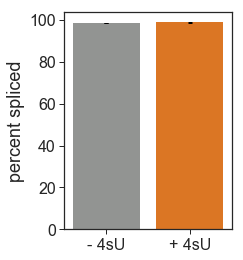

In [19]:
# plot the global percent spliced of samples in read
# box plots show the means and bars are ranges between the two samples

N = len(plot_percentSpliced_matrix_df)
ind = np.arange(N)  # the x locations for the groups

labels = plot_percentSpliced_matrix_df['sample'].values
mean = plot_percentSpliced_matrix_df['average'].values
err = plot_percentSpliced_matrix_df['max']-mean

fig, ax = plt.subplots(figsize=(3,4))
fill_color=['grey','orange']

g = sns.barplot(labels,mean,palette=sns.xkcd_palette(fill_color))
g.errorbar(ind, mean, yerr=err, fmt="none", ecolor="black", elinewidth=1, capsize=2)

# add some text for labels, title and axes ticks
g.set_title('', fontsize=20)

# label x-axis
g.set_xticks(ind)
x_labels=['- 4sU','+ 4sU']
g.set_xticklabels(x_labels, fontsize=16)

# add ticks to axes
ax.tick_params(direction='out', length=5, width=1)

# label y-axis
plt.rc('ytick', labelsize=16)
g.set_ylabel('percent spliced', fontsize=18)

# save image for figure
plt.savefig('/path/to/Supplemental_Figure_1B_4sU_TimeLapse_percent_spliced_plot.pdf',
            format='pdf', dpi=300, bbox_inches='tight')

plt.show()

In [20]:
# get values for Fisher exact test and Chi squared test
no4sU_spliced = int(splicing_index_matrix_df[(splicing_index_matrix_df['sample']=="no4sU") & (splicing_index_matrix_df['replicate']=="1")]['spliced_count'])
no4sU_unspliced = int(splicing_index_matrix_df[(splicing_index_matrix_df['sample']=="no4sU") & (splicing_index_matrix_df['replicate']=="1")]['unspliced_count'])
plus4sU_spliced = int(splicing_index_matrix_df[(splicing_index_matrix_df['sample']=="plus4sU") & (splicing_index_matrix_df['replicate']=="1")]['spliced_count'])
plus4sU_unspliced = int(splicing_index_matrix_df[(splicing_index_matrix_df['sample']=="plus4sU") & (splicing_index_matrix_df['replicate']=="1")]['unspliced_count'])

#np.array([[no4sU_spliced, no4sU_unspliced], [plus4sU_spliced, plus4sU_unspliced]])

oddsratio, pvalue = stats.fisher_exact([[no4sU_spliced, no4sU_unspliced], [plus4sU_spliced, plus4sU_unspliced]])
print("Fisher exact odds ratio: "+str(oddsratio)) # the same equation in R shows that this is <2.2e-16
print("Fisher exact p-value: "+str(pvalue)) # the same equation in R shows that this is <2.2e-16

g, pvalue, dof, expctd = chi2_contingency(np.array([[no4sU_spliced, no4sU_unspliced], [plus4sU_spliced, plus4sU_unspliced]]))
print("chi-square p-value: "+str(pvalue))  # the same equation in R shows that this is <2.2e-16



Fisher exact odds ratio: 0.9007232082825141
Fisher exact p-value: 1.0922889930533244e-43
chi-square p-value: 8.603662101434883e-44


In [21]:
# SUPPLEMENTAL FIGURE 1C - +/- 4sU splicing index comparisons

# make a variable for threshold
t = 100

# get PSI values for all samples
no4sU_1_SI = get_SI_TL('no4sU_1', t)
no4sU_2_SI = get_SI_TL('no4sU_2', t)
plus4sU_1_SI = get_SI_TL('plus4sU_1', t)
plus4sU_2_SI = get_SI_TL('plus4sU_2', t)

# merge all samples to make sure we are comparing the same genes
merged_genes = pd.merge(no4sU_1_SI,no4sU_2_SI,on=['gene'],how="inner")
merged_genes = pd.merge(merged_genes,plus4sU_1_SI,on=['gene'],how="inner")
merged_genes = pd.merge(merged_genes,plus4sU_2_SI,on=['gene'],how="inner")[['gene']]

# merge dataframes to plot PSI distribution
no4sU_1_merge = pd.merge(no4sU_1_SI,merged_genes,on=['gene'],how="inner")
no4sU_1_merge['name']="no4sU_1"
no4sU_2_merge = pd.merge(no4sU_2_SI,merged_genes,on=['gene'],how="inner")
no4sU_2_merge['name']="no4sU_2"
plus4sU_1_merge = pd.merge(plus4sU_1_SI,merged_genes,on=['gene'],how="inner")
plus4sU_1_merge['name']="plus4sU_1"
plus4sU_2_merge = pd.merge(plus4sU_2_SI,merged_genes,on=['gene'],how="inner")
plus4sU_2_merge['name']="plus4sU_2"

merge = pd.concat([no4sU_1_merge,no4sU_2_merge,plus4sU_1_merge,plus4sU_2_merge]).reset_index()


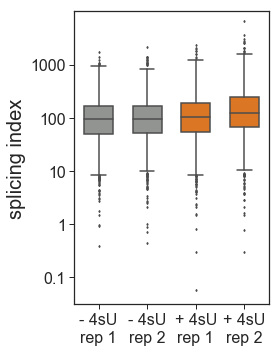

In [22]:
# plot figure
fig, ax = plt.subplots(figsize=(4,5))

fill_color=['grey','grey','orange','orange']
ax = sns.boxplot(x='name', y='log_SI', data=merge, width=0.6, linewidth=1.5, 
                 palette=sns.xkcd_palette(fill_color), fliersize=1.5)
#sns.despine(offset=10, trim=True)

# label y axis
plt.ylabel("splicing index", fontsize=20)
y_labels = ["0.1","1","10","100","1000"]
plt.yticks([-1,0,1,2,3], y_labels, fontsize=16)
#plt.ylim(-1.5,4)

# label x axis
x_labels = ["- 4sU\nrep 1","- 4sU\nrep 2","+ 4sU\nrep 1","+ 4sU\nrep 2"]
plt.xticks([0,1,2,3], x_labels, fontsize=16)
plt.xlabel("", fontsize=20)

# add ticks to axes
ax.tick_params(direction='out', length=5, width=1)

ax.set_ylim(-1.5,4)

plt.tight_layout()

# save image for figure
plt.savefig('/path/to/Supplemental_Figure_1C_4sU_TimeLapse_splicing_index_plot.pdf',
            format='pdf', dpi=300, bbox_inches='tight')

plt.show()


In [23]:
# T test statistics

names = ['no4sU','plus4sU']

stats_list = []

for i in range(0,len(names)-1):
    for j in range(i+1,len(names)):

        name1="%s_1_merge" % names[i]
        name2="%s_1_merge" % names[j]
        
        t, p = ttest_ind(eval(name1)['log_SI'],eval(name2)['log_SI'], nan_policy='omit', equal_var=False)
        stats_list.append(['rep1', names[i], names[j], t, p])

        name1="%s_2_merge" % names[i]
        name2="%s_2_merge" % names[j]
        
        t, p = ttest_ind(eval(name1)['log_SI'],eval(name2)['log_SI'], nan_policy='omit', equal_var=False)
        stats_list.append(['rep2', names[i], names[j], t, p])

        
Ttest_stats_df = pd.DataFrame(stats_list)
Ttest_stats_df.columns = ['sample', 'name_1', 'name_2', 'T value', 'p-value']

Ttest_stats_df       


,sample,name_1,name_2,T value,p-value
0,rep1,no4sU,plus4sU,-4.605520,4.198167e-06
1,rep2,no4sU,plus4sU,-12.258479,3.840499e-34


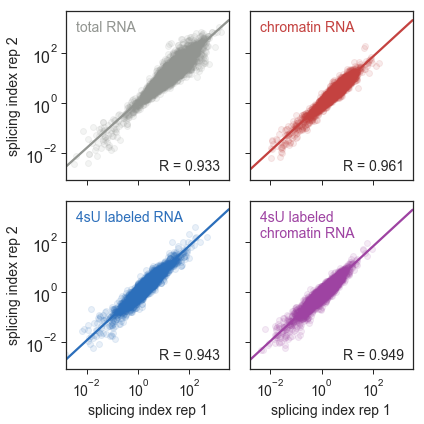

In [24]:
# SUPPLEMENTAL FIGURE 1E - splicing index correlation plots for all Illumina RNA-seq datasets

# make a variable for threshold
t = 100

# get SI values for all samples
tot_1_SI = get_SI('tot_1', t)
chr_1_SI = get_SI('chr_1', t)
lab_1_SI = get_SI('4sU_1', t)
labchr_1_SI = get_SI('4sUchr_1', t)
tot_2_SI = get_SI('tot_2', t)
chr_2_SI = get_SI('chr_2', t)
lab_2_SI = get_SI('4sU_2', t)
labchr_2_SI = get_SI('4sUchr_2', t)


# merge replicates to plot comparisons
tot_merge_SI = pd.merge(tot_1_SI,tot_2_SI,on=['gene'],how="inner")
chr_merge_SI = pd.merge(chr_1_SI,chr_2_SI,on=['gene'],how="inner")
lab_merge_SI = pd.merge(lab_1_SI,lab_2_SI,on=['gene'],how="inner")
labchr_merge_SI = pd.merge(labchr_1_SI,labchr_2_SI,on=['gene'],how="inner")


# make a correlation plot for all replicate samples
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2, nrows=2, sharex=True, sharey=True, figsize=(6,6))

# plot for total RNA sample
sns.regplot(x=tot_merge_SI['log_SI_x'],y=tot_merge_SI['log_SI_y'],scatter=True,\
            color=sns.xkcd_rgb["grey"], scatter_kws={'alpha':0.1}, ax=ax1)
ax1.set_xlabel('')
ax1.set_ylabel('splicing index rep 2',fontsize=14)
ax1.text(-2.4,3.3,'total RNA',horizontalalignment='left',verticalalignment='top',fontsize=14, color=sns.xkcd_rgb["grey"])
pcor = np.corrcoef(tot_merge_SI['log_SI_x'], tot_merge_SI['log_SI_y'])[0, 1]
ax1.text(3.2,-2.8,"R = "+str(round(pcor,3)),horizontalalignment='right',verticalalignment='bottom',fontsize=14)

# plot for chromatin RNA sample
sns.regplot(x=chr_merge_SI['log_SI_x'],y=chr_merge_SI['log_SI_y'],scatter=True,\
            color=sns.xkcd_rgb["reddish"], scatter_kws={'alpha':0.1}, ax=ax2)
ax2.set_xlabel('')
ax2.set_ylabel('')
ax2.text(-2.4,3.3,'chromatin RNA',horizontalalignment='left',verticalalignment='top',fontsize=14, color=sns.xkcd_rgb["reddish"])
pcor = np.corrcoef(chr_merge_SI['log_SI_x'], chr_merge_SI['log_SI_y'])[0, 1]
ax2.text(3.2,-2.8,"R = "+str(round(pcor,3)),horizontalalignment='right',verticalalignment='bottom',fontsize=14)

# plot for 4sU RNA sample
sns.regplot(x=lab_merge_SI['log_SI_x'],y=lab_merge_SI['log_SI_y'],scatter=True,\
            color=sns.xkcd_rgb["medium blue"], scatter_kws={'alpha':0.1}, ax=ax3)
ax3.set_xlabel('splicing index rep 1',fontsize=14)
ax3.set_ylabel('splicing index rep 2',fontsize=14)
ax3.text(-2.4,3.3,'4sU labeled RNA',horizontalalignment='left',verticalalignment='top', fontsize=14, color=sns.xkcd_rgb["medium blue"])
pcor = np.corrcoef(lab_merge_SI['log_SI_x'], lab_merge_SI['log_SI_y'])[0, 1]
ax3.text(3.2,-2.8,"R = "+str(round(pcor,3)),horizontalalignment='right',verticalalignment='bottom',fontsize=14)

# plot for 4sU labeled chromatin RNA sample
sns.regplot(x=labchr_merge_SI['log_SI_x'],y=labchr_merge_SI['log_SI_y'],scatter=True,\
            color=sns.xkcd_rgb["medium purple"], scatter_kws={'alpha':0.1}, ax=ax4)
ax4.set_xlabel('splicing index rep 1',fontsize=14)
ax4.set_ylabel('')
ax4.text(-2.4,3.3,'4sU labeled\nchromatin RNA',horizontalalignment='left',verticalalignment='top', fontsize=14, color=sns.xkcd_rgb["medium purple"])
pcor = np.corrcoef(labchr_merge_SI['log_SI_x'], labchr_merge_SI['log_SI_y'])[0, 1]
ax4.text(3.2,-2.8,"R = "+str(round(pcor,3)),horizontalalignment='right',verticalalignment='bottom',fontsize=14)

plt.yticks([-2,0,2],["$\mathregular{10^{-2}}$","$\mathregular{10^{0}}$","$\mathregular{10^{2}}$"])
plt.xticks([-2,0,2],["$\mathregular{10^{-2}}$","$\mathregular{10^{0}}$","$\mathregular{10^{2}}$"])

ax1.tick_params(axis='both', direction='out', length=5, width=1)
ax2.tick_params(axis='both', direction='out', length=5, width=1)
ax3.tick_params(axis='both', direction='out', length=5, width=1)
ax4.tick_params(axis='both', direction='out', length=5, width=1)

plt.tight_layout()

plt.savefig('/path/to/Supplemental_Figure_1E_SI_correlation_plots.pdf', 
           format='pdf', dpi=300, bbox_inches='tight')

plt.show()



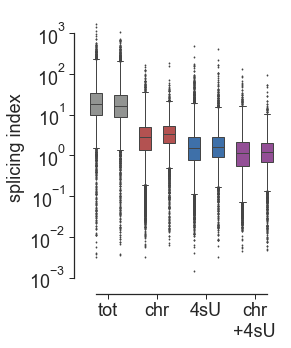

In [50]:
# SUPPLEMENTAL FIGURE 1F - PSI boxplots for all Illumina RNA-seq replicates

# plot PSI distribution for all replicates independently 
samples=[tot_1_SI['log_SI'],tot_2_SI['log_SI'],chr_1_SI['log_SI'],chr_2_SI['log_SI'],lab_1_SI['log_SI'],lab_2_SI['log_SI'],labchr_1_SI['log_SI'],labchr_2_SI['log_SI']]
fill_color=['grey','grey','reddish','reddish','medium blue','medium blue','medium purple','medium purple']

plt.figure(figsize=(3.5,5))
sns.boxplot(data=samples,width=0.5,linewidth=1, palette=sns.xkcd_palette(fill_color),fliersize=1)
sns.despine(offset=10, trim=True)

plt.ylabel("splicing index", fontsize=18)
plt.yticks(fontsize=16)

x_labels = ["tot","chr","4sU","chr\n+4sU"]
plt.xticks([0.5,2.5,4.5,6.5], x_labels, fontsize=18)

y_labels = ["$\mathregular{10^{-3}}$","$\mathregular{10^{-2}}$","$\mathregular{10^{-1}}$","$\mathregular{10^{0}}$","$\mathregular{10^{1}}$","$\mathregular{10^{2}}$","$\mathregular{10^{3}}$"]
plt.yticks([-3,-2,-1,0,1,2,3], y_labels, fontsize=18)

plt.tick_params(direction='out', length=5, width=1)

plt.savefig('/path/to/Supplemental_Figure_1F_SI_distribution_plots.pdf', 
           format='pdf', dpi=300, bbox_inches='tight')

plt.show()


In [54]:
# T test statistics

names = ['tot','chr','lab','labchr']

stats_list = []

for i in range(0,len(names)-1):
    for j in range(i+1,len(names)):

        name1="%s_1_SI" % names[i]
        name2="%s_1_SI" % names[j]
        
        t, p = ttest_ind(eval(name1)['log_SI'],eval(name2)['log_SI'], nan_policy='omit', equal_var=False)
        stats_list.append(['rep1', names[i], names[j], t, p])

        name1="%s_2_SI" % names[i]
        name2="%s_2_SI" % names[j]
        
        t, p = ttest_ind(eval(name1)['log_SI'],eval(name2)['log_SI'], nan_policy='omit', equal_var=False)
        stats_list.append(['rep2', names[i], names[j], t, p])

        
Ttest_stats_df = pd.DataFrame(stats_list)
Ttest_stats_df.columns = ['sample', 'name_1', 'name_2', 'T value', 'p-value']

Ttest_stats_df       


,sample,name_1,name_2,T value,p-value
0,rep1,tot,chr,121.717753,0.000000e+00
1,rep2,tot,chr,95.650944,0.000000e+00
2,rep1,tot,lab,147.029433,0.000000e+00
3,rep2,tot,lab,121.532104,0.000000e+00
4,rep1,tot,labchr,170.661825,0.000000e+00
5,rep2,tot,labchr,144.863685,0.000000e+00
6,rep1,chr,lab,30.907367,1.638756e-205
7,rep2,chr,lab,34.706728,6.470669e-251
8,rep1,chr,labchr,53.719873,0.000000e+00
9,rep2,chr,labchr,55.932112,0.000000e+00


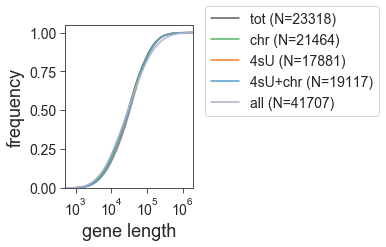

In [76]:
# SUPPLEMENTAL FIGURE 1G - gene length distribution

# collect gene lengths
hg38_genes_df = pd.read_csv('/path/to/annotation_files/NCBI_RefSeq_hg38_genes_parsed.bed',header=None, sep='\t')
hg38_genes_df = hg38_genes_df[hg38_genes_df[9]>1]
hg38_genes_df = hg38_genes_df.drop([6,7,8,9,10,11], axis=1) # drop irrelevant columns from dataframe
hg38_genes_df.columns = ['chrom','start','end','transcript','gene_length','strand']
hg38_genes_df['gene_length'] = hg38_genes_df['end']-hg38_genes_df['start']
hg38_genes_df['transcript'] = hg38_genes_df.apply(lambda row: row['transcript'].split('.')[0], axis=1)
hg38_genes_df = hg38_genes_df.drop_duplicates(subset=['transcript']).reset_index(drop=True)

# make a variable for threshold
t = 25

# get SI values for all samples
tot_1_SI = get_SI('tot_1', t)
chr_1_SI = get_SI('chr_1', t)
lab_1_SI = get_SI('4sU_1', t)
labchr_1_SI = get_SI('4sUchr_1', t)

# get feature count values for total RNA
tot_1_featureCount = get_featureCount('tot_1')
chr_1_featureCount = get_featureCount('chr_1')
lab_1_featureCount = get_featureCount('4sU_1')
labchr_1_featureCount = get_featureCount('4sUchr_1')

tot_1_featureCount['transcript'] = tot_1_featureCount['gene'].apply(lambda x: x.split(".")[0])
chr_1_featureCount['transcript'] = chr_1_featureCount['gene'].apply(lambda x: x.split(".")[0])
lab_1_featureCount['transcript'] = lab_1_featureCount['gene'].apply(lambda x: x.split(".")[0])
labchr_1_featureCount['transcript'] = labchr_1_featureCount['gene'].apply(lambda x: x.split(".")[0])

# collect names of transcripts that are in Figure 1B
tot_transcripts_plot = set(tot_1_featureCount[tot_1_featureCount['exon_RPKM']>1]['transcript'])
chr_transcripts_plot = set(chr_1_featureCount[chr_1_featureCount['exon_RPKM']>1]['transcript'])
lab_transcripts_plot = set(lab_1_featureCount[lab_1_featureCount['exon_RPKM']>1]['transcript'])
labchr_transcripts_plot = set(labchr_1_featureCount[labchr_1_featureCount['exon_RPKM']>1]['transcript'])
all_transcripts_plot = set(hg38_genes_df['transcript'])

# collect lengths of transcripts that are in Figure 1B
tot_transcripts_plot_df = hg38_genes_df[hg38_genes_df['transcript'].isin(tot_transcripts_plot)].reset_index(drop=True)
chr_transcripts_plot_df = hg38_genes_df[hg38_genes_df['transcript'].isin(chr_transcripts_plot)].reset_index(drop=True)
lab_transcripts_plot_df = hg38_genes_df[hg38_genes_df['transcript'].isin(lab_transcripts_plot)].reset_index(drop=True)
labchr_transcripts_plot_df = hg38_genes_df[hg38_genes_df['transcript'].isin(labchr_transcripts_plot)].reset_index(drop=True)
all_transcripts_plot_df = hg38_genes_df[hg38_genes_df['transcript'].isin(all_transcripts_plot)].reset_index(drop=True)

# make figure
fig, ax = plt.subplots(figsize=(2.3,3))

tot_transcripts_plot_length = np.log10(tot_transcripts_plot_df['gene_length'].values)
chr_transcripts_plot_length = np.log10(chr_transcripts_plot_df['gene_length'].values)
lab_transcripts_plot_length = np.log10(lab_transcripts_plot_df['gene_length'].values)
labchr_transcripts_plot_length = np.log10(labchr_transcripts_plot_df['gene_length'].values)
all_transcripts_plot_length = np.log10(all_transcripts_plot_df['gene_length'].values)

ax = sns.distplot(tot_transcripts_plot_length, hist=False, kde_kws=dict(cumulative=True), color = sns.color_palette("Greys")[4], bins=100, label='tot (N='+str(len(tot_transcripts_plot_df))+')')
sns.distplot(chr_transcripts_plot_length, hist=False, kde_kws=dict(cumulative=True), color = sns.color_palette("Greens")[3], bins=100, label='chr (N='+str(len(chr_transcripts_plot_df))+')')
sns.distplot(lab_transcripts_plot_length, hist=False, kde_kws=dict(cumulative=True), color = sns.color_palette("Oranges")[3], bins=100, label='4sU (N='+str(len(lab_transcripts_plot_df))+')')
sns.distplot(labchr_transcripts_plot_length, hist=False, kde_kws=dict(cumulative=True), color = sns.color_palette("Blues")[3], bins=100, label='4sU+chr (N='+str(len(labchr_transcripts_plot_df))+')')
sns.distplot(all_transcripts_plot_length, hist=False, kde_kws=dict(cumulative=True), color = sns.color_palette("Purples")[2], bins=100, label='all (N='+str(len(all_transcripts_plot_df))+')')

x_labels = ["$\mathregular{10^{3}}$","$\mathregular{10^{4}}$","$\mathregular{10^{5}}$","$\mathregular{10^{6}}$"]
plt.xticks([3,4,5,6], x_labels, fontsize=16)
plt.yticks(fontsize=16)

ax.tick_params(axis='both', which='both', labelsize=14, direction='out', left="on", bottom="on", length=5)
ax.set_ylabel("frequency", fontsize=18)
ax.set_xlabel("gene length", fontsize=18)
ax.legend(bbox_to_anchor=[2.5,0.4], loc=4, fontsize=14)

plt.xlim(2.7,6.3)
#plt.xlim(4,5)

plt.savefig('/path/to/Supplemental_Figure_1G_Illumina_gene_length_cdf_plot.pdf', 
           format='pdf', dpi=300, bbox_inches='tight')

plt.show()


In [82]:
# T test statistics

names = ['tot','chr','lab','labchr']

stats_list = []

for i in range(0,len(names)):

    sample_1="%s_transcripts_plot_length" % names[i]
    sample_2="chr_transcripts_plot_length"

    t, p = ttest_ind(eval(sample_1), eval(sample_2), nan_policy='omit', equal_var=False)
    stats_list.append([names[i], "chr", t, p])
        
Ttest_stats_df = pd.DataFrame(stats_list)
Ttest_stats_df.columns = ['name_1', 'name_2', 'T value', 'p-value']

Ttest_stats_df       


,name_1,name_2,T value,p-value
0,tot,chr,-1.656858,9.755530e-02
1,chr,chr,0.000000,1.000000e+00
2,lab,chr,7.923883,2.363894e-15
3,labchr,chr,5.666968,1.463395e-08


In [78]:
dif = np.median(labchr_transcripts_plot_df['gene_length'].values)-np.median(chr_transcripts_plot_df['gene_length'].values)
percent = dif / np.median(labchr_transcripts_plot_df['gene_length'].values)
print(percent)


0.06480184303103888


In [84]:
np.median(all_transcripts_plot_df['gene_length'].values)

29337.0

In [83]:
np.median(tot_transcripts_plot_df['gene_length'].values)

29402.5

In [80]:
np.median(chr_transcripts_plot_df['gene_length'].values)

30039.5

In [85]:
np.median(lab_transcripts_plot_df['gene_length'].values)

33335.0

In [81]:
np.median(labchr_transcripts_plot_df['gene_length'].values)

32121.0